In [11]:
"""CPP analysis"""

__author__    = "Thomas Fransson"
__credit__    = ["Thomas Fransson"]

__copyright__ = "(c) 2021, ENCSS and PDC"
__license__   = "MIT"
__date__      = "2021-05-06"

<figure>
  <IMG SRC="../../img/ENCCS-PDC-logos.jpg" WIDTH=150 ALIGN="right">
</figure>

# Analysis of CPP results

<div style="background: #efffed;
            border: 1px solid grey;
            margin: 8px 0 8px 0;
            text-align: center;
            padding: 8px; ">
    <i class="fa-play fa" 
       style="font-size: 40px;
              line-height: 40px;
              margin: 8px;
              color: #444;">
    </i>
    <div>
    To run the selected code cell, hit <pre style="background: #efffed">Shift + Enter</pre>
    </div>
</div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt     
import numpy as np 
from scipy.interpolate import interp1d
eV = 27.2114

# Example 1: vinylfluoride

### Input file

```
@jobs
task: response
@end

@method settings
xcfun: b3lyp
basis: def2-svp
@end

@response
property: absorption (cpp)
frequencies: 10.05 - 10.37 (0.0025)
damping: 0.01
@end

@molecule
charge: 0
multiplicity: 1
xyz:
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
@end
```

## Load data for analysis
Here saved in .npy-object - can alternatively use hdf5-format

In [2]:
data = np.load('vinylfluoride.npy', allow_pickle=True)
scf_E = data[0][1]; mo_E  = data[1][1]; nocc  = data[2][1]; nvirt = data[3][1]; freqs = data[4][1]
axx   = data[5][1]; ayy   = data[6][1]; azz   = data[7][1]
x_solution = data[8][1]; y_solution = data[9][1]; z_solution = data[10][1]
print('SCF energy:',scf_E)
print('Occupied MO energies:',mo_E[:nocc])

SCF energy: -177.68966209046528
Occupied MO energies: [-24.69342438 -10.27018896 -10.18747364  -1.20405927  -0.76597437
  -0.60515048  -0.53206822  -0.48506863  -0.46039734  -0.41430941
  -0.37450458  -0.26981574]


## Extract spectra (isotropic and for each Cartesian component)
Printing isotropic results - compare to output-file from your calculation

In [3]:
n_freq = len(freqs)
sigma,sxx,syy,szz = np.zeros(n_freq),np.zeros(n_freq),np.zeros(n_freq),np.zeros(n_freq)
print('Freq. [au]  Freq [eV]  Sigma(w) [au]')
indx = 0
for w in freqs:
    axx_tmp = axx[indx]; ayy_tmp = ayy[indx]; azz_tmp = azz[indx]
    a_bar = (axx_tmp + ayy_tmp + azz_tmp) / 3.0
    sigma[indx] = (4.0 * np.pi * w * a_bar   / 137.035999)
    sxx[indx]   = (4.0 * np.pi * w * axx_tmp / 137.035999)
    syy[indx]   = (4.0 * np.pi * w * ayy_tmp / 137.035999)
    szz[indx]   = (4.0 * np.pi * w * azz_tmp / 137.035999)
    print(' {0:.4f}    {1:.4f}    {2:.8f}'.format(w,w*eV, sigma[indx]))
    indx += 1

Freq. [au]  Freq [eV]  Sigma(w) [au]
 10.0500    273.4746    0.00845762
 10.0525    273.5426    0.00899523
 10.0550    273.6106    0.00960043
 10.0575    273.6787    0.01028567
 10.0600    273.7467    0.01106644
 10.0625    273.8147    0.01196217
 10.0650    273.8827    0.01299751
 10.0675    273.9508    0.01420404
 10.0700    274.0188    0.01562271
 10.0725    274.0868    0.01730729
 10.0750    274.1549    0.01932928
 10.0775    274.2229    0.02178513
 10.0800    274.2909    0.02480674
 10.0825    274.3589    0.02857705
 10.0850    274.4270    0.03335308
 10.0875    274.4950    0.03949933
 10.0900    274.5630    0.04753392
 10.0925    274.6311    0.05818320
 10.0950    274.6991    0.07241525
 10.0975    274.7671    0.09134172
 10.1000    274.8351    0.11567469
 10.1025    274.9032    0.14413677
 10.1050    274.9712    0.17074302
 10.1075    275.0392    0.18447787
 10.1100    275.1073    0.17750124
 10.1125    275.1753    0.15429935
 10.1150    275.2433    0.12619319
 10.1175    275.31

## Compare to experiment
Plotting above results as well as line spectrum constructed with a cubic spline.\
Results shifted to align with first experimental feature.

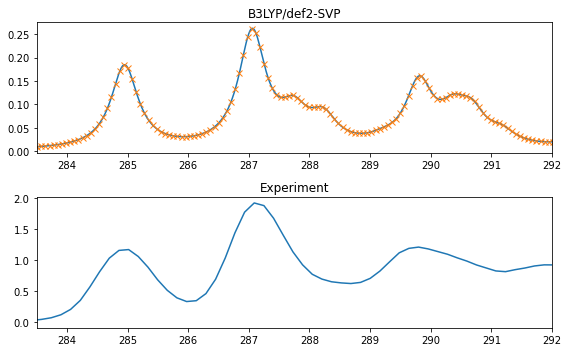

In [4]:
data = np.loadtxt('expt_vin'); E,I = [],[]
for i in np.arange(len(data)): E.append(data[i][0]); I.append(data[i][1])
x = np.arange(min(freqs*eV),max(freqs*eV),0.01)
y = interp1d(freqs*eV, sigma, kind='cubic')
xmin,xmax = 283.5,292
plt.figure(figsize=(8,5))
plt.subplot(211); plt.title('B3LYP/def2-SVP')
shft = 275.05-284.95
plt.plot(x-shft,y(x))
plt.plot(freqs*eV-shft,sigma,'x')
plt.xlim((xmin,xmax))
plt.subplot(212); plt.title('Experiment')
plt.plot(E,I); plt.xlim((xmin,xmax))
plt.tight_layout(); plt.show()

## Resolving cartesian components
Dominated by out-of-plane contributions due to $1s \rightarrow \pi^{\ast}$ transitions.\
(Note the factor of 1/3 for the components, which is there to make the sum equal to the isotropic average)

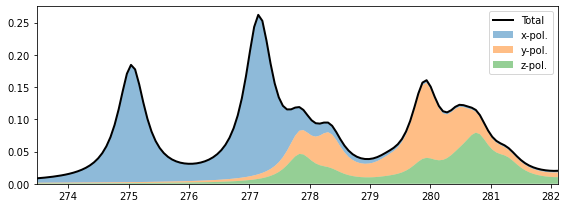

In [5]:
plt.figure(figsize=(8,3))
plt.plot(freqs*eV,sigma,linewidth=2,color='k')
plt.fill_between(freqs*eV,(sxx+syy+szz)/3.,(syy+szz)/3.,alpha=0.5)
plt.fill_between(freqs*eV,(syy+szz)/3.,(szz)/3.,alpha=0.5)
plt.fill_between(freqs*eV,(szz)/3.,alpha=0.5)
plt.legend(('Total','x-pol.','y-pol.','z-pol.'))
plt.xlim((eV*min(freqs),eV*max(freqs))); plt.ylim((0,1.05*max(sigma))); plt.tight_layout()

## Resolving contributions to the spectrum
- Extract information for each solution vector (one per cartesian component)
- Sum contributions from each occupied orbital, normalized by all contributions
- Scale with corresponding cartesian component and sum up

### For vinylfluoride
- Two strong $1s \rightarrow \pi^{\ast}$ transitions from each carbon 1s
- Bond to electronegative fluoride decrease electron density around carbon, leading to higher transition energy for that carbon
    - Results in chemical shift of about 2 eV between -CH$_2$ (MO #3 )and -CHF (MO #2)

<IPython.core.display.Javascript object>


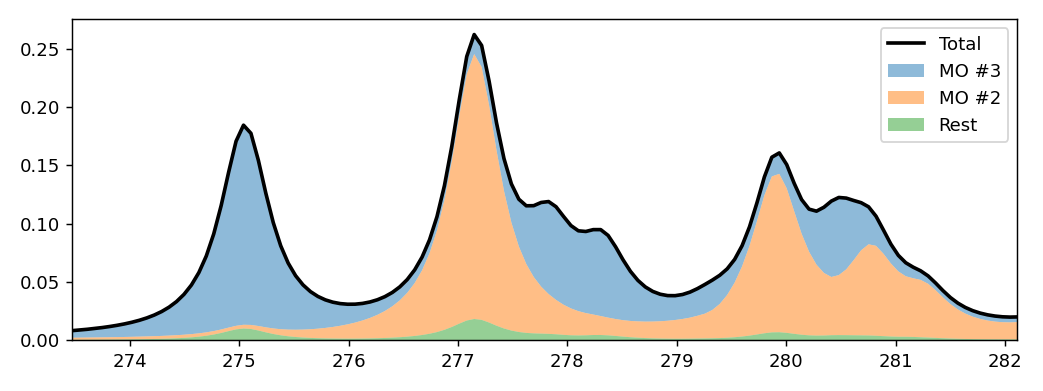

In [109]:
spec_comp = []
for occ in np.arange(0,nocc): spec_comp.append([])
for i in np.arange(len(freqs)):
    x_tmp = x_solution[i]; y_tmp = y_solution[i]; z_tmp = z_solution[i]
    for occ in np.arange(0,nocc):
        comp_X = np.sum(np.abs(np.imag(x_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(x_tmp[:])))
        comp_Y = np.sum(np.abs(np.imag(y_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(y_tmp[:])))
        comp_Z = np.sum(np.abs(np.imag(z_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(z_tmp[:])))
        spec_comp[occ].append((comp_X*sxx[i]+comp_Y*syy[i]+comp_Z*szz[i])/3.)
plt.figure(figsize=(8,3))
mo2 = np.array(spec_comp[1]); mo3 = np.array(spec_comp[2])
plt.plot(eV*freqs,sigma,linewidth=2,color='k')
plt.fill_between(eV*freqs,sigma,sigma-mo3,alpha=0.5)
plt.fill_between(eV*freqs,sigma-mo3,sigma-mo2-mo3,alpha=0.5)
plt.fill_between(eV*freqs,sigma-mo2-mo3,alpha=0.5)
plt.legend(('Total','MO #3','MO #2','Rest'))
plt.xlim((eV*min(freqs),eV*max(freqs))); plt.ylim((0,1.05*max(sigma))); plt.tight_layout()

# Example 2: free-based porphyrin

### Input file

```
@jobs
task: response
@end

@method settings
xcfun: b3lyp
basis: def2-svp
@end

@response
property: absorption (cpp)
frequencies: 10.01 - 10.17 (0.0016)
@end

@molecule
charge: 0
multiplicity: 1
xyz:
H 3.209599995 3.172309777 0.000000000
N 0.000000000 -2.113600613 0.000000000
N 2.031813914 0.000000000 0.000000000
N 0.000000000 2.113600613 0.000000000
N -2.031813914 0.000000000 0.000000000
C 1.126850920 -2.888627221 0.000000000
C -1.126850920 -2.888627221 0.000000000
C 1.126850920 2.888627221 0.000000000
C -1.126850920 2.888627221 0.000000000
C 2.850160984 -1.083939750 0.000000000
C 2.850160984 1.083939750 0.000000000
C -2.850160984 -1.083939750 0.000000000
C -2.850160984 1.083939750 0.000000000
C 0.683827200 -4.249372023 0.000000000
C -0.683827200 -4.249372023 0.000000000
C 0.683827200 4.249372023 0.000000000
C -0.683827200 4.249372023 0.000000000
C 4.248378966 -0.675836785 0.000000000
C 4.248378966 0.675836785 0.000000000
C -4.248378966 -0.675836785 0.000000000
C -4.248378966 0.675836785 0.000000000
C 2.433989580 -2.416542873 0.000000000
C -2.433989580 -2.416542873 0.000000000
C -2.433989580 2.416542873 0.000000000
C 2.433989580 2.416542873 0.000000000
H 1.341416542 -5.103998738 0.000000000
H -1.341416542 -5.103998738 0.000000000
H 1.341416542 5.103998738 0.000000000
H -1.341416542 5.103998738 0.000000000
H 5.096138011 -1.344322017 0.000000000
H 5.096138011 1.344322017 0.000000000
H -5.096138011 -1.344322017 0.000000000
H -5.096138011 1.344322017 0.000000000
H 3.209599995 -3.172309777 0.000000000
H -3.209599995 -3.172309777 0.000000000
H -3.209599995 3.172309777 0.000000000
H 0.000000000 -1.102285542 0.000000000
H 0.000000000 1.102285542 0.000000000
@end
```

## Extract data
Note: put imaginary part of solution vectors in individual .npy-objects due to size restrictions

In [6]:
data = np.load('porphyrin.npy', allow_pickle=True)
scf_E = data[0][1]; mo_E  = data[1][1]; nocc  = data[2][1]; nvirt = data[3][1]; freqs = data[4][1]
axx   = data[5][1]; ayy   = data[6][1]; azz   = data[7][1]
data = np.load('porphyrin_xsol.npy', allow_pickle=True); x_solution = data[0][1]
data = np.load('porphyrin_ysol.npy', allow_pickle=True); y_solution = data[0][1]
data = np.load('porphyrin_zsol.npy', allow_pickle=True); z_solution = data[0][1]
print('SCF energy:',scf_E)
print('Occupied MO energies:',mo_E[:nocc])

SCF energy: -988.846789451356
Occupied MO energies: [-14.36571353 -14.36567718 -14.29726407 -14.29724436 -10.2346608
 -10.23465985 -10.23461365 -10.23461259 -10.21399217 -10.21398711
 -10.21395811 -10.2139439  -10.19982834 -10.19979859 -10.19978915
 -10.1997608  -10.19891496 -10.19891005 -10.19840644 -10.19840466
 -10.18305353 -10.18305317 -10.18245953 -10.18245919  -0.98593338
  -0.98457207  -0.93826255  -0.93595213  -0.81473496  -0.79447264
  -0.78942936  -0.78830085  -0.78197827  -0.75126257  -0.75105253
  -0.73975876  -0.71637088  -0.660265    -0.65228424  -0.60211999
  -0.5985902   -0.59482371  -0.58763362  -0.57975414  -0.57432231
  -0.55748809  -0.54864912  -0.51846492  -0.50900355  -0.50293899
  -0.49720082  -0.46345696  -0.45016034  -0.44840504  -0.44422393
  -0.44051952  -0.43581741  -0.43245719  -0.43082684  -0.42195254
  -0.41796924  -0.40622335  -0.40070568  -0.39385577  -0.3876026
  -0.38439895  -0.38397333  -0.37826254  -0.37120953  -0.37070973
  -0.33168562  -0.29310501

## Extract spectra (isotropic and for each Cartesian component)
Printing isotropic results - compare to output-file from your calculation

In [7]:
n_freq = len(freqs)
sigma,sxx,syy,szz = np.zeros(n_freq),np.zeros(n_freq),np.zeros(n_freq),np.zeros(n_freq)
print('Freq. [au]  Freq [eV]  Sigma(w) [au]')
indx = 0
for w in freqs:
    axx_tmp = axx[indx]; ayy_tmp = ayy[indx]; azz_tmp = azz[indx]
    a_bar = (axx_tmp + ayy_tmp + azz_tmp) / 3.0
    sigma[indx] = (4.0 * np.pi * w * a_bar   / 137.035999)
    sxx[indx]   = (4.0 * np.pi * w * axx_tmp / 137.035999)
    syy[indx]   = (4.0 * np.pi * w * ayy_tmp / 137.035999)
    szz[indx]   = (4.0 * np.pi * w * azz_tmp / 137.035999)
    print(' {0:.4f}    {1:.4f}    {2:.8f}'.format(w,w*eV, sigma[indx]))
    indx += 1

Freq. [au]  Freq [eV]  Sigma(w) [au]
 10.0100    272.3861    0.03394428
 10.0116    272.4297    0.03562486
 10.0132    272.4732    0.03747407
 10.0148    272.5167    0.03951717
 10.0164    272.5603    0.04178452
 10.0180    272.6038    0.04431293
 10.0196    272.6473    0.04714739
 10.0212    272.6909    0.05034341
 10.0228    272.7344    0.05397024
 10.0244    272.7780    0.05811522
 10.0260    272.8215    0.06288996
 10.0276    272.8650    0.06843910
 10.0292    272.9086    0.07495301
 10.0308    272.9521    0.08268675
 10.0324    272.9956    0.09198883
 10.0340    273.0392    0.10334595
 10.0356    273.0827    0.11745468
 10.0372    273.1263    0.13533906
 10.0388    273.1698    0.15854834
 10.0404    273.2133    0.18949454
 10.0420    273.2569    0.23202214
 10.0436    273.3004    0.29228766
 10.0452    273.3440    0.37962676
 10.0468    273.3875    0.50480366
 10.0484    273.4310    0.66539440
 10.0500    273.4746    0.80845439
 10.0516    273.5181    0.84833233
 10.0532    273.56

## Compare to experiment
Plotting above results as well as line spectrum constructed with a cubic spline.\
Results shifted to align with first experimental feature.

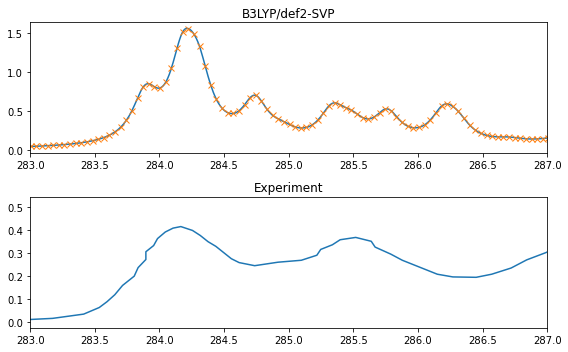

In [8]:
data = np.loadtxt('expt_h2p_25'); E,I = [],[]
for i in np.arange(len(data)): E.append(data[i][0]); I.append(data[i][1])
x = np.arange(min(freqs*eV),max(freqs*eV),0.01)
y = interp1d(freqs*eV, sigma, kind='cubic')
xmin,xmax = 283,287
plt.figure(figsize=(8,5))
plt.subplot(211); plt.title('B3LYP/def2-SVP')
shft = 273.7-284.1
plt.plot(x-shft,y(x))
plt.plot(freqs*eV-shft,sigma,'x')
plt.xlim((xmin,xmax))
plt.subplot(212); plt.title('Experiment')
plt.plot(E,I); plt.xlim((xmin,xmax))
plt.tight_layout(); plt.show()

## Resolving cartesian components
Almost entirely out-of-plane contributions due to intense and low-energy $1s \rightarrow \pi^{\ast}$ transitions.

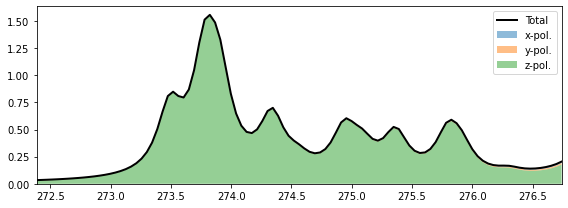

In [9]:
plt.figure(figsize=(8,3))
plt.plot(freqs*eV,sigma,linewidth=2,color='k')
plt.fill_between(freqs*eV,(sxx+syy+szz)/3.,(syy+szz)/3.,alpha=0.5)
plt.fill_between(freqs*eV,(syy+szz)/3.,(szz)/3.,alpha=0.5)
plt.fill_between(freqs*eV,(szz)/3.,alpha=0.5)
plt.legend(('Total','x-pol.','y-pol.','z-pol.'))
plt.xlim((eV*min(freqs),eV*max(freqs))); plt.ylim((0,1.05*max(sigma))); plt.tight_layout()

## Resolving contributions to the spectrum
- Extract information for each solution vector (one per cartesian component)
- Sum contributions from each occupied orbital, normalized by all contributions
- Scale with corresponding cartesian component and sum up

### Note: imaginary part already isolated

### For free-based porphyrin
- Five categories of carbons:
  - Connected to nitrogen (4xNH and 4xN) [MOs 4-7 and 8-11]
  - Bridging [MOs 12-16]
  - Outer carbons (4xNH-group and 4xN-group) [MOs 17-20 and 21-24]

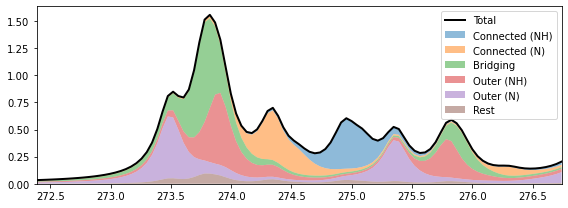

In [10]:
spec_comp = []
for occ in np.arange(0,nocc): spec_comp.append([])
for i in np.arange(len(freqs)):
    x_tmp = x_solution[i]; y_tmp = y_solution[i]; z_tmp = z_solution[i]
    for occ in np.arange(0,nocc):
        comp_X = np.sum(np.abs(x_tmp[occ*nvirt : (occ+1)*nvirt])) / np.sum(np.abs(x_tmp[:]))
        comp_Y = np.sum(np.abs(y_tmp[occ*nvirt : (occ+1)*nvirt])) / np.sum(np.abs(y_tmp[:]))
        comp_Z = np.sum(np.abs(z_tmp[occ*nvirt : (occ+1)*nvirt])) / np.sum(np.abs(z_tmp[:]))
        spec_comp[occ].append((comp_X*sxx[i]+comp_Y*syy[i]+comp_Z*szz[i])/3.)
plt.figure(figsize=(8,3))
plt.plot(eV*freqs,sigma,linewidth=2,color='k')
mo_conn1 = np.array(+np.array(spec_comp[4])+np.array(spec_comp[5])+np.array(spec_comp[6])+np.array(spec_comp[7]))
plt.fill_between(eV*freqs,sigma,sigma-mo_conn1,alpha=0.5)
mo_conn2 = np.array(+np.array(spec_comp[8])+np.array(spec_comp[9])+np.array(spec_comp[10])+np.array(spec_comp[11]))
plt.fill_between(eV*freqs,sigma-mo_conn1,sigma-mo_conn1-mo_conn2,alpha=0.5)
mo_brid = np.array(+np.array(spec_comp[12])+np.array(spec_comp[13])+np.array(spec_comp[14])+np.array(spec_comp[15]))
plt.fill_between(eV*freqs,sigma-mo_conn1-mo_conn2,sigma-mo_conn1-mo_conn2-mo_brid,alpha=0.5)
mo_out1 = np.array(+np.array(spec_comp[16])+np.array(spec_comp[17])+np.array(spec_comp[18])+np.array(spec_comp[19]))
plt.fill_between(eV*freqs,sigma-mo_conn1-mo_conn2-mo_brid,sigma-mo_conn1-mo_conn2-mo_brid-mo_out1,alpha=0.5)
mo_out2 = np.array(+np.array(spec_comp[20])+np.array(spec_comp[21])+np.array(spec_comp[22])+np.array(spec_comp[23]))
plt.fill_between(eV*freqs,sigma-mo_conn1-mo_conn2-mo_brid-mo_out1,sigma-mo_conn1-mo_conn2-mo_brid-mo_out1-mo_out2,alpha=0.5)
plt.fill_between(eV*freqs,sigma-mo_conn1-mo_conn2-mo_brid-mo_out1-mo_out2,alpha=0.5)
plt.legend(('Total','Connected (NH)','Connected (N)','Bridging','Outer (NH)','Outer (N)','Rest'))
plt.xlim((eV*min(freqs),eV*max(freqs))); plt.ylim((0,1.05*max(sigma))); plt.tight_layout()

# Code for running vinylfluoride in Notebook

See for how to extract properties. **NOTE quite slow on Binder: uncomment and execute at your own risk!**

In [ ]:
'''
import veloxchem as vlx
from mpi4py import MPI
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection
from veloxchem import OutputStream
comm = MPI.COMM_WORLD
ostream = OutputStream()
mol_str = """
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
"""
molecule = vlx.Molecule.read_str(mol_str)
basis    = vlx.MolecularBasis.read(molecule, "def2-svp")
scf_settings    = {'conv_thresh': 1.0e-8}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv = vlx.ScfRestrictedDriver(comm,ostream)
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(molecule, basis)
freqs = np.arange(10.05,10.37,0.0025)
freqs_str = [str(x) for x in freqs]
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.01},method_settings)
cpp_prop.init_driver(comm, ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)
axx,ayy,azz = [],[],[]
for w in freqs:
    axx.append(-cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag)
    ayy.append(-cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag)
    azz.append(-cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag)
axx,ayy,azz = np.array(axx),np.array(ayy),np.array(azz)
solution_vecs = cpp_prop.get_property('solutions')
x_solution,y_solution,z_solution = [],[],[]
for w in freqs:
    x_solution.append(solution_vecs[('x',w)]); y_solution.append(solution_vecs[('y',w)]); z_solution.append(solution_vecs[('z',w)])
x_solution,x_solution,x_solution = np.array(x_solution),np.array(y_solution),np.array(z_solution)
nocc  = molecule.number_of_alpha_electrons()
nvirt = scf_drv.mol_orbs.number_mos() - nocc
mo_E  = scf_drv.scf_tensors['E']
scf_E = scf_drv.get_scf_energy()
'''